In [9]:
import pandas as pd
import numpy as np
import joblib
geo = pd.read_csv('/app/spark/Olist/raw_data/olist_geolocation_dataset.csv')
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region
0,1037,-23.545621,-46.639292,sao paulo,SP,남동부
1,1046,-23.546081,-46.644820,sao paulo,SP,남동부
2,1046,-23.546129,-46.642951,sao paulo,SP,남동부
3,1041,-23.544392,-46.639499,sao paulo,SP,남동부
4,1035,-23.541578,-46.641607,sao paulo,SP,남동부


#### 다이어 크리틱 제거 
 - 다이어 크리틱 문자때문에 중복된 행이 발생함.

In [10]:
import unicodedata

def remove_diacritics(input_str):
    return ''.join(c for c in unicodedata.normalize('NFKD', input_str) if not unicodedata.combining(c))

# 적용하기
geo['geolocation_city'] = geo['geolocation_city'].apply(remove_diacritics)

##### 위-경도가 [zip_code, eolocation_city,geolocation_state,geolocation_region]과 일치하지 않는 경우가 존재함.
    - 아이솔레이션 포레스트를 사용하여 이상값을 확인

In [11]:
geo[geo['geolocation_state'] == 'RJ'].iloc[np.random.randint(1,100,5)]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region
404279,20040,-22.906800,-43.176623,rio de janeiro,RJ,남동부
404278,20010,-22.902464,-43.175824,rio de janeiro,RJ,남동부
404313,20010,-22.899407,-43.177201,rio de janeiro,RJ,남동부
404314,20061,-22.905912,-43.186572,rio de janeiro,RJ,남동부
404351,20030,-22.910488,-43.172642,rio de janeiro,RJ,남동부


In [12]:
# Isolation Forest 적용 (위도, 경도만 사용)
X = geo[['geolocation_lat', 'geolocation_lng']]

In [14]:
'''
from sklearn.ensemble import IsolationForest
model = IsolationForest(
    n_estimators=100, max_samples="auto", n_jobs=-1, max_features=2, contamination=0.01
)

model.fit(X)  # 👉 fit 먼저!


joblib.dump(model, '/app/spark/Olist/model/isolation_forest.pkl')

'''
model = joblib.load('/app/spark/Olist/model/isolation_forest.pkl')

# 5. 예측
geo['anomaly_score'] = model.predict(X)


-  상파울루주(SP)의 위,경도와 상이한 값을 갖는 행들을 볼 수 있음
    - 약 1만개의 행이 이상값을 가지고 있음

In [15]:
geo.loc[geo['anomaly_score']==-1].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score
345301,14915,-1.888416,-55.121428,curupa,SP,남동부,-1
387565,18243,28.008978,-15.536867,bom retiro da esperanca,SP,남동부,-1
399300,19274,-10.893066,-61.932123,primavera,SP,남동부,-1
513631,28165,41.614052,-8.411675,vila nova de campos,RJ,남동부,-1
513640,28145,-8.741506,-63.907933,sao sebastiao de campos,RJ,남동부,-1


In [16]:
geo.loc[geo['anomaly_score']==-1].shape

(9961, 7)

- KNN imputer 를 사용하여 해당 이상값들의 위 경도를 갖는 state로 대체함
    - 도메인 및 eda 결과 geolocation_city의 경우 이상값이 없었음

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
normal_geo = geo.loc[geo['anomaly_score']!=-1].copy()

le = LabelEncoder()
normal_geo['geo_encoded'] = le.fit_transform(normal_geo['geolocation_state'])
X,y= normal_geo[['geolocation_lat','geolocation_lng']].copy() ,normal_geo['geo_encoded'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
'''
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
joblib.dump(rf,'/app/spark/Olist/model/rf.pkl')
'''


(990202, 2) (990202,)


In [19]:
rf = joblib.load('/app/spark/Olist/model/rf.pkl')
y_pred= rf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
def print_metrics(y_true,y_pred,aver='binary'):
  print('accuracy',accuracy_score(y_true,y_pred))
  print('recall',recall_score(y_true,y_pred,average=aver))
  print('precision',precision_score(y_true,y_pred,average=aver))
  print('f1_score',f1_score(y_true,y_pred, average=aver))

  cfm = confusion_matrix(y_true,y_pred)
  s = sns.heatmap(cfm,annot=True,cmap='Blues',fmt='d',cbar=False)
  s.set(xlabel='Actual',ylabel='Prediction')
  plt.show()
     

accuracy 0.9997037645466756
recall 0.9194795537571472
precision 0.9188056589467105
f1_score 0.9191407301338244


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


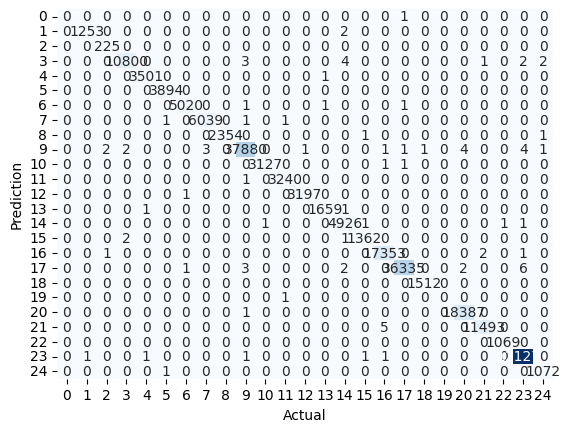

In [21]:

print_metrics(y_test,y_pred,aver='macro')

In [22]:
le.inverse_transform(y_pred)

array(['SP', 'RJ', 'RS', ..., 'SC', 'ES', 'SP'], dtype=object)

- 이상치 대체

In [100]:
outliers = geo.loc[geo['anomaly_score']==-1].copy()
X = outliers[['geolocation_lat','geolocation_lng']]
y_pred = rf.predict(X)
le.inverse_transform(y_pred)

array(['PA', 'PE', 'MT', ..., 'RS', 'RS', 'RS'], dtype=object)

In [101]:
outliers['geolocation_state'] = le.inverse_transform(y_pred).tolist()
outliers.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score
345301,14915,-1.888416,-55.121428,curupa,PA,남동부,-1
387565,18243,28.008978,-15.536867,bom retiro da esperanca,PE,남동부,-1
399300,19274,-10.893066,-61.932123,primavera,MT,남동부,-1
513631,28165,41.614052,-8.411675,vila nova de campos,PE,남동부,-1
513640,28145,-8.741506,-63.907933,sao sebastiao de campos,PA,남동부,-1


In [112]:
normal_geo.shape , outliers.shape

((990194, 8), (9969, 7))

In [141]:
cleaned_geo = pd.concat([normal_geo, outliers], axis=0)
cleaned_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score,geo_encoded
0,1037,-23.545621,-46.639292,sao paulo,SP,남동부,1,23.0
1,1046,-23.546081,-46.644820,sao paulo,SP,남동부,1,23.0
2,1046,-23.546129,-46.642951,sao paulo,SP,남동부,1,23.0
3,1041,-23.544392,-46.639499,sao paulo,SP,남동부,1,23.0
4,1035,-23.541578,-46.641607,sao paulo,SP,남동부,1,23.0


## 전처리 전후 비교

| Index  | Latitude     | Longitude     | State (Before) | State (After) |
|--------|--------------|---------------|----------------|----------------|
| 345301 | -1.888416    | -55.121428    | SP             | PA             |
| 387565 | 28.008978    | -15.536867    | SP             | PE             |
| 399300 | -10.893066   | -61.932123    | SP             | MT             |
| 513631 | 41.614052    | -8.411675     | RJ             | PE             |
| 513640 | -8.741506    | -63.907933    | RJ             | PA             |


In [142]:
cleaned_geo.shape

(1000163, 8)

- 전처리 확인

In [143]:
geo.loc[geo['anomaly_score']==-1].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score
345301,14915,-1.888416,-55.121428,curupa,SP,남동부,-1
387565,18243,28.008978,-15.536867,bom retiro da esperanca,SP,남동부,-1
399300,19274,-10.893066,-61.932123,primavera,SP,남동부,-1
513631,28165,41.614052,-8.411675,vila nova de campos,RJ,남동부,-1
513640,28145,-8.741506,-63.907933,sao sebastiao de campos,RJ,남동부,-1


In [144]:
idx = [345301,387565,399300,513631,513640]
q = cleaned_geo.loc[idx]
q

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score,geo_encoded
345301,14915,-1.888416,-55.121428,curupa,PA,남동부,-1,NaN
387565,18243,28.008978,-15.536867,bom retiro da esperanca,PE,남동부,-1,NaN
399300,19274,-10.893066,-61.932123,primavera,MT,남동부,-1,NaN
513631,28165,41.614052,-8.411675,vila nova de campos,PE,남동부,-1,NaN
513640,28145,-8.741506,-63.907933,sao sebastiao de campos,PA,남동부,-1,NaN


In [145]:
cleaned_geo=cleaned_geo.reset_index(drop=True)

In [146]:
cleaned_geo

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region,anomaly_score,geo_encoded
0,1037,-23.545621,-46.639292,sao paulo,SP,남동부,1,23.0
1,1046,-23.546081,-46.644820,sao paulo,SP,남동부,1,23.0
2,1046,-23.546129,-46.642951,sao paulo,SP,남동부,1,23.0
3,1041,-23.544392,-46.639499,sao paulo,SP,남동부,1,23.0
4,1035,-23.541578,-46.641607,sao paulo,SP,남동부,1,23.0
...,...,...,...,...,...,...,...,...
1000158,95130,14.585073,121.105394,santa lucia do piai,PE,남부,-1,NaN
1000159,98780,-36.605374,-64.283946,santa rosa,RS,남부,-1,NaN
1000160,98780,-31.418865,-60.336265,santa rosa,RS,남부,-1,NaN
1000161,98780,-36.603837,-64.287433,santa rosa,RS,남부,-1,NaN


In [ ]:
cleaned_geo.drop(['geo_encoded','anomaly_score'],axis=1,inplace=True)
hash_map = {
    'SP': '남동부', 'RJ': '남동부', 'MG': '남동부',
    'RS': '남부', 'PR': '남부', 'SC': '남부',
    'BA': '북동부', 'DF': '중서부', 'ES': '남동부',
    'GO': '중서부', 'PE': '북동부', 'CE': '북동부',
    'PA': '북부', 'MT': '중서부', 'MA': '북동부',
    'MS': '중서부', 'PB': '북동부', 'PI': '북동부',
    'RN': '북동부', 'AL': '북동부', 'SE': '북동부',
    'TO': '북부', 'RO': '북부', 'AM': '북부',
    'AC': '북부', 'AP': '북부', 'RR': '북부'
}
# state가 바뀌었으므로 다시 매핑
cleaned_geo['geolocation_region']= cleaned_geo['geolocation_state'].map(hash_map)

In [149]:
cleaned_geo.to_csv('/app/spark/Olist/dim_table/dim_geo.csv',index=False)